In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta # to add days or years
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as offlin
import numpy as np
from plotly.graph_objs import Scatter, Figure, Layout
import matplotlib.pyplot as plt



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/crime_merged.csv', index_col = [0])
df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Other Asian,Native Hawaiian and Other Pacific Islander,Native Hawaiian,Chamorro,Samoan,Other Pacific Islander,Some other race,ZipCode,Median_Income,Mean_Income
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,96,36,9,0,10,17,2103,60644,28033,44694
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,249,0,0,0,0,0,150,60661,125365,148266


# Clustering into high threat - medium threat and low threat zones

In [ ]:
community_data = pd.read_csv('del.csv').dropna(axis = 1)
features = ['GEOID', 'EMP', 'UNEMP' ]

community_data_clean = community_data[features].rename(columns = {'GEOID': 'Community_Area'}).set_index('Community_Area')
community_data_clean['unEmpRate'] = community_data_clean['UNEMP'] / (community_data_clean['EMP'] + community_data_clean['UNEMP'] )
community_data_clean = community_data_clean.drop(['EMP', 'UNEMP'], axis = 1)


In [ ]:
clustering_df = df.rename(columns =  {col : col.replace(' ', '_') for col in df.columns}).copy()[['Community_Area', 'ID', 'Arrest', 'Median_Income', 'Mean_Income']]
total = clustering_df.groupby(['Community_Area']).agg({ 'ID' : 'count', 'Median_Income' : 'mean', 'Mean_Income' : 'mean', 'Arrest' : 'sum'}).rename(columns = {'ID' : 'Total_incidents'})

crime_rate = total.copy()
crime_rate['arrest_rate'] = crime_rate['Arrest']/crime_rate['Total_incidents']
clustering_df_ = crime_rate.copy().drop(columns = [ 'Median_Income', 'Arrest', 'Total_incidents']).merge(community_data_clean, left_index=True, right_index=True, how='inner')



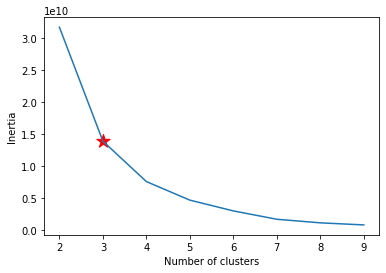

In [ ]:
from sklearn.cluster import KMeans
X = np.array(clustering_df_)
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init = "k-means++")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias)
plt.scatter(3,inertias[1], s = 200, c = 'red', marker='*')
#plt.scatter(4,inertias[2], s = 200, c = 'violet', marker='*')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
##It gives an idea of how well the objects are classified taking that number of clusters
from sklearn.metrics import silhouette_score
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, init = "k-means++")
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean', n_jobs=-1)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6597618999699131)
For n_clusters = 3, silhouette score is 0.6103696017120112)
For n_clusters = 4, silhouette score is 0.5502904847284514)
For n_clusters = 5, silhouette score is 0.5668141708056252)
For n_clusters = 6, silhouette score is 0.5678350933158309)
For n_clusters = 7, silhouette score is 0.5943723606642095)
For n_clusters = 8, silhouette score is 0.5746324571495547)
For n_clusters = 9, silhouette score is 0.5605183531122279)


In [ ]:
kmeans = KMeans(n_clusters=3, init = "k-means++")
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
pred = y_kmeans
kmeans = clustering_df_.copy()
kmeans['Label'] = pred
#kmeans = kmeans.reset_index() 

print('silhouette_score: ',silhouette_score(X, pred, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, pred))
print('davies_bouldin_score: ', davies_bouldin_score(X, pred))

silhouette_score:  0.6103696017120112
calinski_harabasz_score:  165.91530964650258
davies_bouldin_score:  0.5114096026097562


In [ ]:
clustering_df_

,Mean_Income,arrest_rate,unEmpRate
Community_Area,,,
1.0,76435.966637,0.163951,0.046249
2.0,63755.237821,0.122120,0.063082
3.0,86387.481583,0.170394,0.032943
4.0,67919.082546,0.124316,0.053677
5.0,62946.580416,0.099801,0.031921
...,...,...,...
73.0,71780.807082,0.181626,0.142472
74.0,51525.945192,0.123317,0.044178
75.0,81304.817335,0.176910,0.106394


In [ ]:

PLOT = go.Figure()

for C in list(kmeans.Label.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = kmeans[kmeans.Label == C]['Mean_Income'],
                                y = kmeans[kmeans.Label == C]['unEmpRate'],
                                z = kmeans[kmeans.Label == C]['arrest_rate'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Mean Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Umemployement rate', titlefont_color = 'black'),
                                zaxis=dict(title = 'arrest_rate', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
Community_Area_mapping_kmeans = { row['Community_Area']: row['Label']  for i,row in kmeans.reset_index().iterrows()}
mapping_ = df_.groupby(['Community_Area'])['Latitude', 'Longitude'].agg('min').reset_index()
mapping_kmeans = mapping_.copy()
mapping_kmeans["Label"] = mapping_kmeans['Community_Area'].apply(lambda x: Community_Area_mapping_kmeans[x] if x in Community_Area_mapping_kmeans else None)
mapping_kmeans = mapping_kmeans.dropna()
colors_map = {0 : '#636EFA', 1: '#EF553B', 2: '#FFA15A'}
mapping_kmeans["color"] = mapping_kmeans['Label'].apply(lambda x: colors_map[x] )
fig = px.scatter_mapbox( mapping_kmeans , lat="Latitude", lon="Longitude",
                        color = 'Label', zoom=9, height=650)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

<ipython-input-39-a8d6561fb113>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
kmeans.groupby('Label').mean()

,Mean_Income,arrest_rate,unEmpRate
Label,,,
0,103273.439421,0.199024,0.128591
1,62142.932432,0.154469,0.097555
2,209258.677192,0.169821,0.041588


## Gaussian Mixture Models

In [ ]:
from sklearn.mixture import GaussianMixture

# define the model
gm = GaussianMixture(n_components=3)
# fit model and predict clusters
yhat = gm.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
  	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot

print('silhouette_score: ',silhouette_score(X, yhat, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, yhat))
print('davies_bouldin_score: ', davies_bouldin_score(X, yhat))

silhouette_score:  0.517326241455773
calinski_harabasz_score:  128.40155425299184
davies_bouldin_score:  0.578257427253753


<Figure size 1080x1080 with 0 Axes>

In [ ]:
gmm_df = clustering_df_.copy()
gmm_df['Label'] = yhat
gmm_df.head(3)

,Mean_Income,arrest_rate,unEmpRate,Label
Community_Area,,,,
1.0,76435.966637,0.163951,0.046249,0
2.0,63755.237821,0.122120,0.063082,0
3.0,86387.481583,0.170394,0.032943,0


In [ ]:

PLOT = go.Figure()

for C in list(gmm_df.Label.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = gmm_df[gmm_df.Label == C]['Mean_Income'],
                                y = gmm_df[gmm_df.Label == C]['unEmpRate'],
                                z = gmm_df[gmm_df.Label == C]['arrest_rate'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Mean Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Umemployement rate', titlefont_color = 'black'),
                                zaxis=dict(title = 'arrest_rate', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
Community_Area_mapping_gmm = { row['Community_Area']: row['Label']  for i,row in gmm_df.reset_index().iterrows()}
mapping_gmm = mapping_.copy()
mapping_gmm["Label"] = mapping_gmm['Community_Area'].apply(lambda x: Community_Area_mapping_gmm[x] if x in Community_Area_mapping_gmm else None)
mapping_gmm = mapping_gmm.dropna()
colors_map = {0 : '#636EFA', 1: '#EF553B', 2: '#FFA15A'}
mapping_gmm["color"] = mapping_gmm['Label'].apply(lambda x: colors_map[x] )
fig = px.scatter_mapbox( mapping_gmm , lat="Latitude", lon="Longitude",
                        color = 'Label', zoom=9, height=650)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [ ]:
gmm_df.groupby('Label').mean()

,Mean_Income,arrest_rate,unEmpRate
Label,,,
0,62528.306294,0.149195,0.086533
1,209258.677192,0.169821,0.041588
2,100740.748840,0.208375,0.150719


# Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_agg = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat_agg)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
#plt.show()

print('silhouette_score: ',silhouette_score(X, yhat_agg, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, yhat_agg))
print('davies_bouldin_score: ', davies_bouldin_score(X, yhat_agg))


silhouette_score:  0.5831591943812339
calinski_harabasz_score:  138.85726579448016
davies_bouldin_score:  0.6032999948910085


<Figure size 1080x1080 with 0 Axes>

In [ ]:
agg_df = clustering_df_.copy()
agg_df['Label'] = yhat_agg
agg_df.head(3)

,Mean_Income,arrest_rate,unEmpRate,Label
Community_Area,,,,
1.0,76435.966637,0.163951,0.046249,1
2.0,63755.237821,0.122120,0.063082,1
3.0,86387.481583,0.170394,0.032943,2


In [ ]:
PLOT = go.Figure()

for C in list(agg_df.Label.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = agg_df[agg_df.Label == C]['Mean_Income'],
                                y = agg_df[agg_df.Label == C]['unEmpRate'],
                                z = agg_df[agg_df.Label == C]['arrest_rate'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Mean Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Umemployement rate', titlefont_color = 'black'),
                                zaxis=dict(title = 'arrest_rate', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
Community_Area_mapping_agg = { row['Community_Area']: row['Label']  for i,row in agg_df.reset_index().iterrows()}
mapping_agg = mapping_.copy()
mapping_agg["Label"] = mapping_agg['Community_Area'].apply(lambda x: Community_Area_mapping_agg[x] if x in Community_Area_mapping_agg else None)
mapping_agg = mapping_agg.dropna()
colors_map = {0 : '#636EFA', 1: '#EF553B', 2: '#FFA15A'}
mapping_agg["color"] = mapping_agg['Label'].apply(lambda x: colors_map[x] )
fig = px.scatter_mapbox( mapping_agg , lat="Latitude", lon="Longitude",
                        color = 'Label', zoom=9, height=650)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [ ]:
agg_df.groupby('Label').mean()

,Mean_Income,arrest_rate,unEmpRate
Label,,,
0,166207.507168,0.176949,0.050592
1,62142.932432,0.154469,0.097555
2,98138.446261,0.201622,0.139391


## Classification using GMM cluster label

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
gmm_df_classification = gmm_df.merge(community_data_clean, left_index=True, right_index=True, how='inner')
gmm_df_classification.corr()['Label'].sort_values()

Total_incidents   -0.603957
UNEMP             -0.582020
Arrest            -0.553493
NOT_IN_LBFRC      -0.492663
UND5              -0.448954
2020_POP          -0.440756
A5_19             -0.415612
A50_64            -0.408957
arrest_rate       -0.406419
A75_84            -0.403676
2020_HH           -0.393072
A20_34            -0.379079
A35_49            -0.362333
A65_74            -0.361203
IN_LBFRC          -0.357751
EMP               -0.327155
OV85              -0.310842
2020_HH_SIZE       0.110537
MED_AGE            0.235901
Label              1.000000
Name: Label, dtype: float64

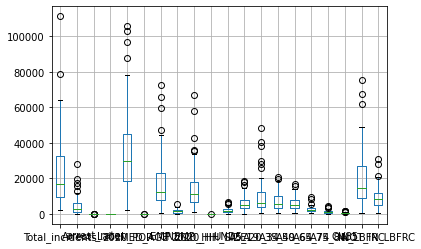

In [ ]:
gmm_df_classification.boxplot()

In [ ]:
X_class = RobustScaler().fit_transform(gmm_df_classification.copy().drop(columns = ['Label', 'Total_incidents', 'Arrest']))
y_class = gmm_df_classification['Label']
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2,random_state=1)

In [ ]:
##Instantiate the classifier
dt = DecisionTreeClassifier(random_state=1)
lr = LogisticRegression(random_state=1)
knn = KNeighborsClassifier()

In [ ]:
Classifiers = {'LogisticRegression':lr,'KNearestNeighbors':knn,'DecisionTreeClassifier':dt}
for clf_name,clf in Classifiers.items():
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print('{:s}:{:.3f}'.format(clf_name,accuracy_score(y_test,y_pred)))

LogisticRegression:0.812
KNearestNeighbors:0.875
DecisionTreeClassifier:0.812


In [ ]:
X_test.shape

(16, 19)

#### Type of crime

In [ ]:
df_.columns

Index(['Latitude', 'Longitude', 'ID', 'Case_Number', 'DateTime', 'Block',
       'IUCR', 'Primary_Type', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community_Area', 'FBI_Code', 'Zipcode', 'Median_Income',
       'Mean_Income', 'Date', 'week', 'day', 'month'],
      dtype='object')

In [ ]:
df_.groupby(['Community_Area', 'Primary_Type']).count()['ID']

Community_Area  Primary_Type                     
1.0             ARSON                                  22
                ASSAULT                              2063
                BATTERY                              5439
                BURGLARY                             1171
                CONCEALED CARRY LICENSE VIOLATION       1
                                                     ... 
77.0            ROBBERY                               594
                SEX OFFENSE                           106
                STALKING                               21
                THEFT                                5877
                WEAPONS VIOLATION                      77
Name: ID, Length: 2284, dtype: int64

In [ ]:
df_['Primary_Type'].unique()

array(['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'BURGLARY', 'ROBBERY',
       'OTHER OFFENSE', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT',
       'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'CRIM SEXUAL ASSAULT',
       'LIQUOR LAW VIOLATION', 'ARSON', 'STALKING', 'KIDNAPPING',
       'INTIMIDATION', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON - CRIMINAL', 'HUMAN TRAFFICKING', 'OBSCENITY',
       'CRIMINAL SEXUAL ASSAULT', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'HOMICIDE',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], dtype=object)

In [ ]:
!pip install pystan~=2.14 --q
!pip install fbprophet --q

     |████████████████████████████████| 67.3 MB 141 kB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from fbprophet import Prophet

data = pd.read_csv('/content/drive/MyDrive/Datasets/crime_merged.csv', index_col = [0]) 

df = data[['ID','Date','Primary Type','Location Description','Arrest','Domestic','Zipcode']]

df.Date = pd.to_datetime(df.Date,format = '%m/%d/%Y %I:%M:%S %p')
df.index = pd.DatetimeIndex(df.Date)

primary_types= ['All'] + list(set(df["Primary Type"]))
zipcodes = ['All'] + list(set(df["Zipcode"])) 

incident_option = input()
zipcode_option = input()

df_new = df.copy()

if incident_option != 'All':
  df_new = df_new[df_new['Primary Type'] == incident_option]

if zipcode_option != 'All':
  df_new = df_new[df_new['Zipcode'] == int(zipcode_option)]

df_prophet = pd.DataFrame(df_new.resample('M').size().reset_index())

df_prophet.columns = ['Date','Crime Count']
df_prophet = df_prophet.rename(columns={'Date':'ds','Crime Count':'y'})

m = Prophet()
m.fit(df_prophet)

pred = m.make_future_dataframe(periods=12,freq='M')
forecast = m.predict(pred)


px.line(forecast,x="ds",y="yhat")


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


All
60606


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
plot = build_and_plot(df, incident_option, zipcode_option)

ValueError: ignored

In [ ]:
df[df['Zipcode'] == 60606]

,ID,Date,Primary Type,Location Description,Arrest,Domestic,Zipcode
Date,,,,,,,
2015-09-05 16:21:00,10224868,2015-09-05 16:21:00,BATTERY,PARKING LOT/GARAGE(NON.RESID.),False,False,60606
2015-09-05 20:01:00,10224997,2015-09-05 20:01:00,WEAPONS VIOLATION,SIDEWALK,True,False,60606
2015-09-05 23:55:00,10225121,2015-09-05 23:55:00,GAMBLING,SIDEWALK,True,False,60606
2015-09-05 21:35:00,10225131,2015-09-05 21:35:00,DECEPTIVE PRACTICE,VEHICLE NON-COMMERCIAL,True,False,60606
2015-09-05 23:30:00,10225149,2015-09-05 23:30:00,THEFT,STREET,False,False,60606
...,...,...,...,...,...,...,...
2022-09-15 07:00:00,12828070,2022-09-15 07:00:00,CRIMINAL DAMAGE,STREET,False,False,60606
2022-09-21 00:23:00,12834091,2022-09-21 00:23:00,MOTOR VEHICLE THEFT,STREET,False,False,60606
2022-09-21 05:20:00,12834190,2022-09-21 05:20:00,BATTERY,STREET,False,False,60606


In [ ]:
df['Zipcode'].unique()

array([60644, 60661, 60624, 60603, 60619, 60612, 60621, 60608, 60622,
       60607, 60628, 60629, 60827, 60620, 60604, 60643, 60636, 60651,
       60642, 60602, 60654, 60606, 60302, 60632, 60633, 60653])